<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/colab_kaggle_fertilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [30]:
train_data = pd.read_csv('train.csv', index_col='id')
train_data.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [31]:
train_data.shape

(750000, 9)

In [32]:
train_data.drop_duplicates(inplace=True)
train_data.dropna(axis=0)
train_data.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [33]:
train_data.isnull().any().any()

np.False_

In [34]:
for col in train_data.columns:
  unique_values = train_data[col].unique()
  print(f'{col} ({len(unique_values)} unique)')
  print(train_data[col].unique())

Temparature (14 unique)
[37 27 29 35 30 36 28 32 38 26 34 25 33 31]
Humidity (23 unique)
[70 69 63 62 58 59 51 50 61 60 57 72 68 55 52 64 71 56 66 54 65 67 53]
Moisture (41 unique)
[36 65 32 54 43 29 53 44 35 60 27 42 57 47 50 56 33 37 49 39 30 46 61 64
 26 34 51 48 28 38 52 62 55 40 25 59 31 45 58 41 63]
Soil Type (5 unique)
['Clayey' 'Sandy' 'Red' 'Loamy' 'Black']
Crop Type (11 unique)
['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']
Nitrogen (39 unique)
[36 30 24 39 37 10 26 19 25 18 34 42 41 15  4  8  6 31 29 20 28 17 27  7
 12 14 35 33  9 16 40 21 23 32 22 11 38 13  5]
Potassium (20 unique)
[ 4  6 12  2  0 15 17  3 19 16  1 13  7  9 14  8 18 11  5 10]
Phosphorous (43 unique)
[ 5 18 16  4  9 22 35 29  2 12 19 39 30 32 34 40 28 33  0  7 13 24 21 27
 17 26  1 36 23 11 10 20 15 41  3 31  6 14 25 42  8 38 37]
Fertilizer Name (7 unique)
['28-28' '17-17-17' '10-26-26' 'DAP' '20-20' '14-35-14' 'Urea']


In [35]:
train_data.columns

Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [37]:
features = ['Temparature','Nitrogen', 'Soil Type', 'Crop Type', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture']
target = 'Fertilizer Name'
X = train_data[features]
y = train_data[target]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)

In [38]:
y.value_counts(normalize=True)

,proportion
Fertilizer Name,
14-35-14,0.152581
10-26-26,0.151849
17-17-17,0.149937
28-28,0.148211
20-20,0.147852
DAP,0.126480
Urea,0.123089


In [39]:
for col in X.select_dtypes('object'):
  X.loc[:, col], _ = X[col].factorize()
discrete_features = X.dtypes == int
y, _ = pd.factorize(y)

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

,MI Scores
Soil Type,0.005227
Crop Type,0.004392
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966


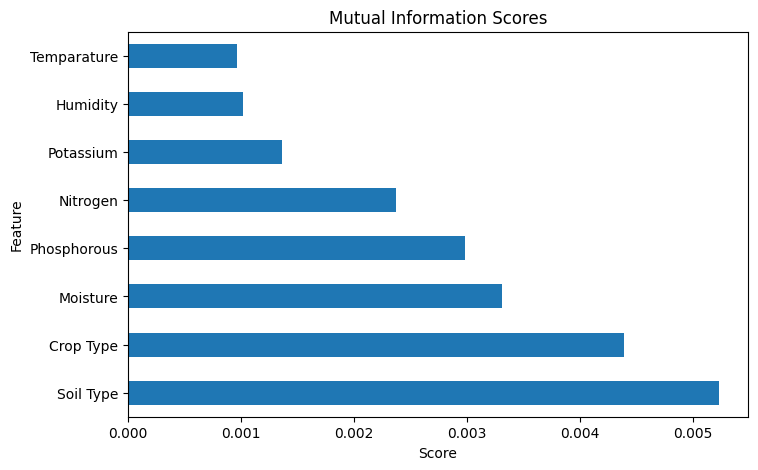

In [40]:
import matplotlib.pyplot as plt

mi_scores.plot(kind="barh", figsize=(8, 5))
plt.title("Mutual Information Scores")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()

In [68]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='mlogloss'))
    ]
)

model.fit(train_X, train_y_encoded)
y_preds_encoded = model.predict(val_X)
y_preds = label_encoder.inverse_transform(y_preds_encoded)

print("Accuracy:", accuracy_score(val_y, y_preds))
print("Classification Report:\n", classification_report(val_y, y_preds))
print("Confusion Matrix:\n", confusion_matrix(val_y, y_preds))

Accuracy: 0.19311466666666666
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.20      0.22      0.21     28487
    14-35-14       0.20      0.26      0.22     28429
    17-17-17       0.20      0.23      0.21     28360
       20-20       0.19      0.20      0.19     27634
       28-28       0.19      0.20      0.20     27937
         DAP       0.20      0.12      0.15     23871
        Urea       0.18      0.08      0.12     22782

    accuracy                           0.19    187500
   macro avg       0.19      0.19      0.19    187500
weighted avg       0.19      0.19      0.19    187500

Confusion Matrix:
 [[6273 5416 4699 4209 4408 2134 1348]
 [4586 7352 4711 4099 4201 1950 1530]
 [4525 5417 6506 4073 4412 1971 1456]
 [4488 5114 4601 5455 4411 2140 1425]
 [4489 5375 4557 4186 5721 2097 1512]
 [3930 4431 3847 3576 3663 2979 1445]
 [3749 4434 3815 3302 3738 1821 1923]]


In [55]:
train_data['NPK_Total'] = train_data[['Nitrogen', 'Potassium', 'Phosphorous']].sum(axis=1).replace(0, 1)
train_data['N_Ratio'] = train_data['Nitrogen'] / train_data['NPK_Total']
train_data['P_Ratio'] = train_data['Phosphorous'] / train_data['NPK_Total']
train_data['K_Ratio'] = train_data['Potassium'] / train_data['NPK_Total']
# Optionally normalize values between 0 and 1
train_data["Temperature_norm"] = (train_data["Temparature"] - train_data["Temparature"].min()) / (train_data["Temparature"].max() - train_data["Temparature"].min())
train_data["Humidity_norm"] = (train_data["Humidity"] - train_data["Humidity"].min()) / (train_data["Humidity"].max() - train_data["Humidity"].min())
train_data["Moisture_norm"] = (train_data["Moisture"] - train_data["Moisture"].min()) / (train_data["Moisture"].max() - train_data["Moisture"].min())

# Simple weather stress index
train_data["WeatherIndex"] = (train_data["Temperature_norm"] + train_data["Humidity_norm"] + train_data["Moisture_norm"]) / 3

In [61]:
feature_ratio = ['Temparature','Nitrogen', 'Soil Type', 'Crop Type', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex', 'N_Ratio', 'P_Ratio', 'K_Ratio', 'NPK_Total']
target_ratio = 'Fertilizer Name'
A = train_data[feature_ratio]
b = train_data[target_ratio]
train_A, val_A, train_b, val_b = train_test_split(A, b, random_state=42)

In [67]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex', 'N_Ratio', 'NPK_Total']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
train_b_encoded = label_encoder.fit_transform(train_b)
val_b_encoded = label_encoder.transform(val_b)

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=200, learning_rate=0.3, max_depth=10))
    ]
)

model.fit(train_A, train_b_encoded)
b_preds_encoded = model.predict(val_A)
b_preds = label_encoder.inverse_transform(b_preds_encoded)

print("Accuracy:", accuracy_score(val_b, b_preds))
print("Classification Report:\n", classification_report(val_b, b_preds))
print("Confusion Matrix:\n", confusion_matrix(val_b, b_preds))

Accuracy: 0.18074133333333334
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.19      0.20      0.19     28487
    14-35-14       0.19      0.22      0.20     28429
    17-17-17       0.19      0.20      0.20     28360
       20-20       0.18      0.19      0.18     27634
       28-28       0.18      0.18      0.18     27937
         DAP       0.18      0.14      0.16     23871
        Urea       0.16      0.12      0.13     22782

    accuracy                           0.18    187500
   macro avg       0.18      0.18      0.18    187500
weighted avg       0.18      0.18      0.18    187500

Confusion Matrix:
 [[5656 4769 4546 4253 4205 2698 2360]
 [4522 6182 4504 4105 4155 2633 2328]
 [4372 4912 5800 4165 4118 2560 2433]
 [4276 4694 4267 5131 4120 2761 2385]
 [4445 4838 4206 4192 5113 2714 2429]
 [3705 4040 3524 3612 3454 3382 2154]
 [3572 3962 3544 3369 3406 2304 2625]]


In [69]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
train_b_encoded = label_encoder.fit_transform(train_b)
val_b_encoded = label_encoder.transform(val_b)

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='mlogloss'))
    ]
)

model.fit(train_A, train_b_encoded)
b_preds_encoded = model.predict(val_A)
b_preds = label_encoder.inverse_transform(b_preds_encoded)

print("Accuracy:", accuracy_score(val_b, b_preds))
print("Classification Report:\n", classification_report(val_b, b_preds))
print("Confusion Matrix:\n", confusion_matrix(val_b, b_preds))

Accuracy: 0.190272
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.19      0.21      0.20     28487
    14-35-14       0.19      0.26      0.22     28429
    17-17-17       0.20      0.23      0.21     28360
       20-20       0.19      0.20      0.19     27634
       28-28       0.18      0.20      0.19     27937
         DAP       0.20      0.12      0.15     23871
        Urea       0.18      0.08      0.11     22782

    accuracy                           0.19    187500
   macro avg       0.19      0.19      0.18    187500
weighted avg       0.19      0.19      0.19    187500

Confusion Matrix:
 [[6067 5521 4792 4280 4381 2124 1322]
 [4738 7359 4706 4063 4161 1948 1454]
 [4570 5506 6528 4155 4316 1903 1382]
 [4635 5142 4629 5512 4279 2101 1336]
 [4392 5502 4626 4324 5476 2163 1454]
 [3958 4483 3782 3617 3769 2940 1322]
 [3735 4466 3835 3461 3660 1831 1794]]


In [44]:
test_data = pd.read_csv('test.csv')
test_X = test_data[features]
test_preds_encoded = model.predict(test_X)

test_preds = label_encoder.inverse_transform(test_preds_encoded)

submission = pd.DataFrame({
    'ID': test_data['id'],
    'Fertilizer Name': test_preds
})

submission.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>